# A

# import libraries

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
%matplotlib inline

# load dataset

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
df = pd.read_csv('/content/drive/MyDrive/Data sets/JEOPARDY_CSV.csv')
df.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [90]:
df.shape

(216930, 7)

In [91]:
df.nunique()


Show Number      3640
 Air Date        3640
 Round              4
 Category       27995
 Value            150
 Question      216124
 Answer         88268
dtype: int64

In [92]:
#show nuber is not significant so dropping column

In [93]:
df.drop('Show Number', axis=1, inplace=True)
df.rename(columns=lambda x: x.strip(), inplace=True)
df = df[~(df['Round'].isin(["Final Jeopardy!", "Tiebreaker"]))]


In [94]:
df

,Air Date,Round,Category,Value,Question,Answer
0,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams
...,...,...,...,...,...,...
216924,2006-05-11,Double Jeopardy!,OFF-BROADWAY,$2000,In 2006 the cast of this long-running hit emba...,Stomp
216925,2006-05-11,Double Jeopardy!,RIDDLE ME THIS,$2000,This Puccini opera turns on the solution to 3 ...,Turandot
216926,2006-05-11,Double Jeopardy!,"""T"" BIRDS",$2000,In North America this term is properly applied...,a titmouse
216927,2006-05-11,Double Jeopardy!,AUTHORS IN THEIR YOUTH,$2000,"In Penny Lane, where this ""Hellraiser"" grew up...",Clive Barker


In [95]:
df['Value'] = df['Value'].str.replace("$", '')
df['Value'] = df['Value'].str.replace(",", '')
df['Value'] = df['Value'].astype(int)
df.head()

,Air Date,Round,Category,Value,Question,Answer
0,2004-12-31,Jeopardy!,HISTORY,200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200,The city of Yuma in this state has a record av...,Arizona
3,2004-12-31,Jeopardy!,THE COMPANY LINE,200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


# EDA

In [96]:
df['Air Date'] = pd.to_datetime(df['Air Date'])
str(df['Air Date'].dt.date.min()) + ' to ' +str(df['Air Date'].dt.date.max())

'1984-09-10 to 2012-01-27'

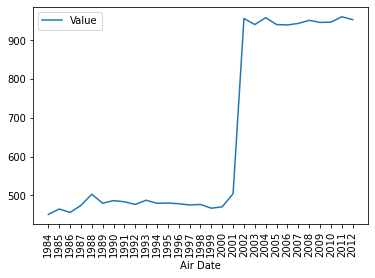

In [97]:
plt_df = df.groupby(df['Air Date'].dt.year).mean('Value')
plt_df.plot(xticks=plt_df.index, rot=90);

In [98]:
#dates has some effect on the values; it can be seen that around 2002 average value increased suddenly.
#Create two baskets fo dates pre-2002 and post-2002

In [99]:
df['air_date_group'] = df['Air Date'].apply(lambda x: 'pre-2002' if x.year < 2002 else 'post-2002')
df.drop('Air Date', axis=1, inplace=True)
df.head()

,Round,Category,Value,Question,Answer,air_date_group
0,Jeopardy!,HISTORY,200,"For the last 8 years of his life, Galileo was ...",Copernicus,post-2002
1,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,post-2002
2,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200,The city of Yuma in this state has a record av...,Arizona,post-2002
3,Jeopardy!,THE COMPANY LINE,200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,post-2002
4,Jeopardy!,EPITAPHS & TRIBUTES,200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,post-2002


In [100]:
#Answer has no significance on the value so dropping

In [101]:
df.drop('Answer', axis=1, inplace=True)
df.head()

,Round,Category,Value,Question,air_date_group
0,Jeopardy!,HISTORY,200,"For the last 8 years of his life, Galileo was ...",post-2002
1,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200,No. 2: 1912 Olympian; football star at Carlisl...,post-2002
2,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200,The city of Yuma in this state has a record av...,post-2002
3,Jeopardy!,THE COMPANY LINE,200,"In 1963, live on ""The Art Linkletter Show"", th...",post-2002
4,Jeopardy!,EPITAPHS & TRIBUTES,200,"Signer of the Dec. of Indep., framer of the Co...",post-2002


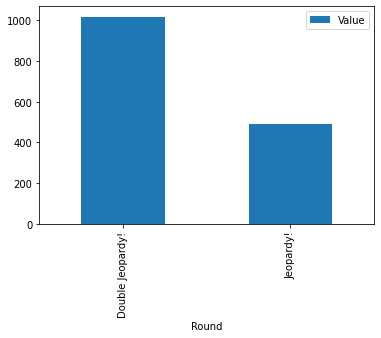

In [102]:
plt_df = df.groupby('Round').mean('Value')
plt_df.plot.bar();

In [103]:
df['Category'].nunique()

26951

In [104]:
#Category has no significance on the value

In [105]:
df.drop('Category', axis=1, inplace=True)

In [106]:
df.head()

,Round,Value,Question,air_date_group
0,Jeopardy!,200,"For the last 8 years of his life, Galileo was ...",post-2002
1,Jeopardy!,200,No. 2: 1912 Olympian; football star at Carlisl...,post-2002
2,Jeopardy!,200,The city of Yuma in this state has a record av...,post-2002
3,Jeopardy!,200,"In 1963, live on ""The Art Linkletter Show"", th...",post-2002
4,Jeopardy!,200,"Signer of the Dec. of Indep., framer of the Co...",post-2002


In [107]:
def binning(value):
    if value < 1000:
        return np.round(value, -2)
    elif value < 10000:
        return np.round(value, -3)
    else:
        return np.round(value, -4)

df['Value'] = df['Value'].apply(binning)

In [108]:
df

,Round,Value,Question,air_date_group
0,Jeopardy!,200,"For the last 8 years of his life, Galileo was ...",post-2002
1,Jeopardy!,200,No. 2: 1912 Olympian; football star at Carlisl...,post-2002
2,Jeopardy!,200,The city of Yuma in this state has a record av...,post-2002
3,Jeopardy!,200,"In 1963, live on ""The Art Linkletter Show"", th...",post-2002
4,Jeopardy!,200,"Signer of the Dec. of Indep., framer of the Co...",post-2002
...,...,...,...,...
216924,Double Jeopardy!,2000,In 2006 the cast of this long-running hit emba...,post-2002
216925,Double Jeopardy!,2000,This Puccini opera turns on the solution to 3 ...,post-2002
216926,Double Jeopardy!,2000,In North America this term is properly applied...,post-2002
216927,Double Jeopardy!,2000,"In Penny Lane, where this ""Hellraiser"" grew up...",post-2002


In [109]:
df.Value.unique()

array([  200,   400,   600,   800,  2000,  1000,  3000,  5000,   100,
         300,   500,  4000,  7000,   700,  8000,  6000, 10000,   900,
        9000,     0, 20000])

In [110]:
df["Value"].value_counts()

400      42247
1000     33789
800      31865
200      30460
2000     25232
600      20379
100       9029
500       9016
300       8663
3000      1077
4000       585
5000       322
700        203
6000       138
900        114
7000        60
10000       45
8000        43
9000        15
0           12
20000        2
Name: Value, dtype: int64

In [111]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [112]:
tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()
def text_preprocessing(text):
    return " ".join([lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)])
df['Question'] = df['Question'].apply(text_preprocessing)
df.head()

,Round,Value,Question,air_date_group
0,Jeopardy!,200,"For the last 8 year of his life, Galileo wa un...",post-2002
1,Jeopardy!,200,No. 2: 1912 Olympian; football star at Carlisl...,post-2002
2,Jeopardy!,200,The city of Yuma in this state ha a record ave...,post-2002
3,Jeopardy!,200,"In 1963, live on ""The Art Linkletter Show"", th...",post-2002
4,Jeopardy!,200,"Signer of the Dec. of Indep., framer of the Co...",post-2002


In [113]:
y = df['Value']
X = df[['Round', 'air_date_group', 'Question']]
column_trans = ColumnTransformer([('Round', OneHotEncoder(dtype='int'),['Round']),
                                  ('air_date_group', OneHotEncoder(dtype='int'),['air_date_group']),
                                  ('Question', TfidfVectorizer(stop_words='english'), 'Question')],
                                remainder='drop')
X = column_trans.fit_transform(X)

In [114]:
X

<213296x87094 sparse matrix of type '<class 'numpy.float64'>'
	with 2223330 stored elements in Compressed Sparse Row format>

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [116]:
df["Value"].value_counts()

400      42247
1000     33789
800      31865
200      30460
2000     25232
600      20379
100       9029
500       9016
300       8663
3000      1077
4000       585
5000       322
700        203
6000       138
900        114
7000        60
10000       45
8000        43
9000        15
0           12
20000        2
Name: Value, dtype: int64

Model Building

In [117]:
!pip install imblearn

In [120]:
!pip install six

In [123]:
!pip install mlrose

In [124]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose

In [125]:
from imblearn.over_sampling import RandomOverSampler


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [141]:
oversample = RandomOverSampler(random_state=42,ratio={20000:500,0:500,9000:500,8000:1000,10000:1000,
                                                       
                                                                  7000:1000,900:2000,6000:2000,700:2000,5000:2000,
                                                                 4000:5000,3000:42000,300:42000,500:42000,100:42000,600:75000,
                                                                 2000:100000,200:100000,800:100000,1000:200000,400:250000})

In [142]:
X_over, y_over = oversample.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (75000) in class 600 will be larger than the number of samples in the majority class (class #400 -> 42247)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (100000) in class 2000 will be larger than the number of samples in the majority class (class #400 -> 42247)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (100000) in class 200 will be larger than the number of samples in the majority class (class #400 -> 42247)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (100000) in class 800 will be larger than the number of samples in the majority class (

In [143]:
from sklearn.model_selection import train_test_split # import train test split from sklearn library

#Split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.30,random_state=42)

SGD Model

In [144]:
%%time
from sklearn.linear_model import SGDClassifier
SGD_clf = SGDClassifier(random_state=10)

SGD_clf.fit(X_train,y_train)
Y_pred=SGD_clf.predict(X_test)

CPU times: user 35 s, sys: 2.13 s, total: 37.1 s
Wall time: 34.6 s


In [145]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

cfm=pd.crosstab(y_test,Y_pred)
print(cfm)

print("Classification report: ")

print(classification_report(y_test,Y_pred))

acc=accuracy_score(y_test, Y_pred)
print("Accuracy of the model: ",acc)

col_0  0      100    200    300    400    ...  7000   8000   9000   10000  20000
row_0                                     ...                                   
0        147      0      0      0      0  ...      0      0      0      0      0
100        0   8345    309   1289   1314  ...      0      0      2      0      3
200       10   1406   7964   1458   8667  ...     10      4      0      0     13
300        3    909    249   8984   1076  ...      0      1      0      0      0
400        7   1301   1440   1716  49622  ...     15     19      1      5     22
500        3    957    289   1218   1113  ...      0      1      0      0      0
600        9     52    667     44   6364  ...      1      6      3      3     14
700        0      3      0      0     43  ...      0      0      0      0      0
800        6     16    474     32   7061  ...     12     14      7      5     14
900        0      0      0      0     17  ...      0      0      0      0      0
1000       8     71    794  

In [148]:
%%time
#Using cross validation

classifier=SGDClassifier(random_state=10) 

#performing kfold_cross_validation
from sklearn.model_selection import KFold
kfold_cv=KFold(n_splits=10)
print(kfold_cv)

from sklearn.model_selection import cross_val_score
#running the model using scoring metric as accuracy
kfold_cv_result=cross_val_score(estimator=classifier,X=X_train,y=y_train, cv=kfold_cv)
print(kfold_cv_result)
#finding the mean
print(kfold_cv_result.mean())

KFold(n_splits=10, random_state=None, shuffle=False)
[0.55919983 0.56088217 0.56768219 0.57623524 0.57490634 0.53209868
 0.55197568 0.56765392 0.55921397 0.55223015]
0.5602078179119248
CPU times: user 4min 56s, sys: 21.1 s, total: 5min 18s
Wall time: 4min 52s


# Conclusion

#The Technique use in Jeopardy dataset is TFidf, upsampling as data was highly imbalanced 
#model use in this is SGD classifier as SGD trains faster for large data set and accuracy is also getting around 56.5%

# STEP- 2

I used wysa app and chat with the bot and my opinions are,
1. we can do the sentiment analysis on the reviews from the app store and play store as from reviews we can get to know were we are lagging, like if user suggest some features, we can add that according to the user Usability.
2. The Bot works well, but when we ask some different things like conversation is going related to anxiety, and you suddenly  ask which car should i buy, bmw or audi, he says blue one. i think little more training needs to bot like when he gets some different question need to handle that situation too.